In [1]:
# import os
# os.environ['MKL_NUM_THREADS'] = '1'
# os.environ['OMP_NUM_THREADS'] = '1'

In [2]:
### For automatically reloading import modules... allows you to run changes to code in jupyter without having to reload
%load_ext autoreload
%autoreload 2

In [3]:
# import zipfile
# import h5py
import os
import sys
import time
import timeit
import pickle
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split

from tqdm import tqdm

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True

from photocatalysis.learners_treesearch import get_population_completed
from photocatalysis.deeplearning.helpers import get_charset, smiles_to_onehot, one_hot_to_smile, plot_model_performance, verify_smile

from photocatalysis.deeplearning.models import VAE, train_epoch

In [4]:
from rdkit import RDLogger

lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

In [5]:
import torch
import torch.optim as optim
import torchinfo

from torch import nn as nn
import torch.nn.functional as F
torch.manual_seed(42)

print(f'CUDA GPU Available: {torch.cuda.is_available()}')

CUDA GPU Available: False


In [6]:
df = pd.read_json('/home/btpq/bt308495/Thesis/frames/DF_COMPLETE.json', orient='split')
df = get_population_completed(df)

In [7]:
input_size = 80
sos_token = 'X'

char_list, max_smi_len = get_charset(df.molecule_smiles, sos_token=sos_token)
X = smiles_to_onehot(df.molecule_smiles, char_list, input_size)
y = df.utility_function.values.astype(np.float32)[:, None]

In [8]:
# 80/5/15 Train/Val/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.75, shuffle=False)

In [9]:
# Convert to Torch Tensor
X_tensor = torch.from_numpy(X)
X_train_tensor = torch.from_numpy(X_train)
y_train_tensor = torch.from_numpy(y_train)

X_valid_tensor = torch.from_numpy(X_valid)
y_valid_tensor = torch.from_numpy(y_valid)

X_test_tensor = torch.from_numpy(X_test)
y_test_tensor = torch.from_numpy(y_test)

# Create Dataset/Dataloader for model training
data_train = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
data_valid = torch.utils.data.TensorDataset(X_valid_tensor, y_valid_tensor)
data_test = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=250, shuffle=True)
valid_loader = torch.utils.data.DataLoader(data_valid, batch_size=250, shuffle=True)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=250, shuffle=True)

# D = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train_tensor[:250], y_train_tensor[:250]), batch_size=250, shuffle=True)

In [10]:
goindex = np.where(char_list == 'X')[0][0]
gotoken = torch.FloatTensor(len(char_list)).zero_()
gotoken[goindex] = 1

## Load Model

In [11]:
def load_model_from_params(params_file, model_training_file, model_weights_file, device='cpu', assert_prob_sample=True):
    # Load Model definition parameters
    with open(params_file, 'rb') as f:
        params = pickle.load(f)

    # Load Training Losses
    with open(model_training_file, 'rb') as f:
        tls, vls = pickle.load(f)

    if assert_prob_sample: params['probabilistic_sampling'] = True
    
    MODEL = VAE(**params).to(device)
    MODEL.load_state_dict(torch.load(model_weights_file, map_location=torch.device(device)))
    MODEL.eval()

    return MODEL, tls, vls

In [12]:
def encode_latent(X_tensor, MODEL):
    with torch.no_grad():
        X = deepcopy(X_tensor)
        X = X.to(device)

        mu_z, logvar_z = MODEL.encode(X)
        z = MODEL.reparameterize(mu_z, logvar_z)

    return z

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
params_file = '/home/btpq/bt308495/Thesis/photocatalysis/workspace/train_teacher_prop/VAE_model_params.pckl'
training_file = '/home/btpq/bt308495/Thesis/photocatalysis/workspace/train_teacher_prop/VAE_losses_epoch60.pckl'
weights_file = '/home/btpq/bt308495/Thesis/photocatalysis/workspace/train_teacher_prop/VAE_model_params_epoch60.pt'

model, tls, vls = load_model_from_params(params_file, training_file, weights_file, device=device)

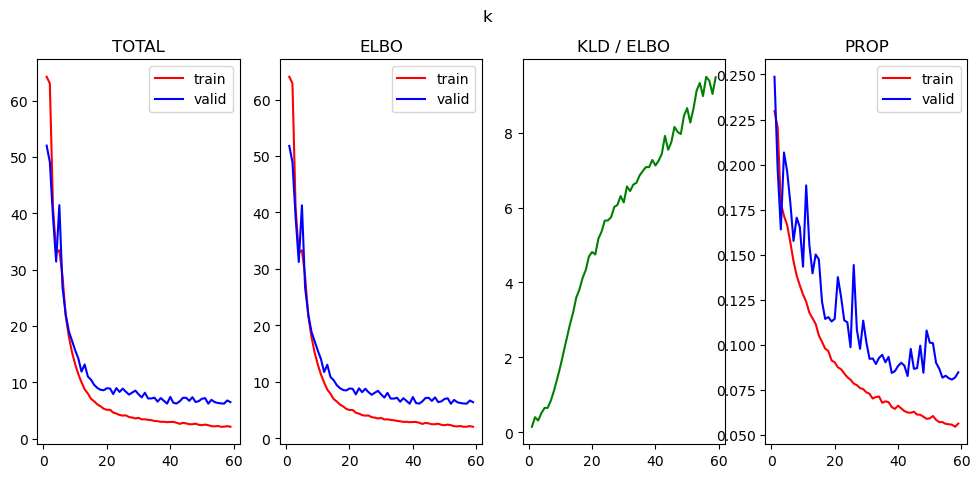

In [14]:
tls, vls = plot_model_performance(tls, vls, name='k')

# GPR

In [ ]:
from sklearn import gaussian_process as gp

In [ ]:
z_train_tensor = encode_latent(X_train_tensor, model)

In [ ]:
# Select a maximally diverse set of initial molecules
# For now, just sample randomly
ri = np.random.randint(z_train_tensor.shape[0], size=2000)
Z, Y = z_train_tensor[ri].numpy(), y_train[ri]

In [ ]:
alpha = 1e-5
n_restarts_optimizer = 10
normalize_y = True
random_state = 42

gpr_prop = gp.GaussianProcessRegressor(alpha=alpha,
                                       n_restarts_optimizer=n_restarts_optimizer,
                                       normalize_y=normalize_y,
                                       random_state=random_state).fit(Z, Y)

In [ ]:
gpr_prop.score(z_train_tensor.numpy(), y_train)

In [ ]:
y_train_pred = gpr_prop.predict(z_train_tensor.numpy())

In [ ]:
plt.scatter(y_train, y_train_pred, alpha=0.5)
plt.plot(y_train, y_train, 'k')

In Bayesian Optimization, we'd like to use a surrogate model (GPR for example) to approximate the utility of unknown regions in the latent space Z, then subsequently optimize an aqcuisition function over the surrogate model to sample regions of this space most likely to contain high performing molecules (i.e. molecules that maximize utility). A candidate molecule is chosen that is expected to have high utility (according to the model), the molecule is evaluated in some black-box fashion (an expensive simulation of the molecules IP/dGmax), and the surrogate model is subsequently retrained on the points it had surveyed before as well as the newly determined point. Re-training 'updates the prior' of the model to incorporate new simulation results.

As a start, instead of optimizing the black box function property=F(molecule), we'll use another surrogate model as a placeholder!

# Bayesian Optimization

In [15]:
from scipy.optimize import minimize
from scipy.stats import norm
from sklearn import gaussian_process as gp
from photocatalysis.evaluate import evaluate_substrate

In [ ]:
def F(zz):
    # Black-box objective function to maximize
    # Normally, would be Utility = F(latent_code)... to do later
    return gpr_prop.predict(zz)

In [16]:
def expected_improvement(X, Y_sampled, surrogate_model, xi=0.01):
    '''
    Computes the EI at points X based on existing samples X_sample
    and Y_sample using a Gaussian process surrogate model.
    
    Args:
        X: Points at which EI shall be computed (m x d).
        Y_sample: Sample values (n x 1).
        surrogate_model: A GaussianProcessRegressor fitted to samples.
        xi: Exploitation-exploration trade-off parameter.
    
    Returns:
        Expected improvements at points X.
    '''
    Y, sigma = surrogate_model.predict(X, return_std=True)
    sigma = sigma.reshape(-1, 1)
    
    best_sampled_Y = np.max(Y_sampled)

    with np.errstate(divide='warn'):
        # EI equation.... where Y (predictions) represents the mean of the surrogate gpr model, and sigma represents the std/uncertainty estimate of the prediction
        imp = Y - best_sampled_Y - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei

In [17]:
def propose_location(acquisition_function, Y_sampled, surrogate_model, bounds, n_restarts=25):
    '''
    Proposes the next sampling point by optimizing the acquisition function over the surrogate model.
    In practice, optimizing this function is much cheaper than directly optimizing an expensive black-box function.
    
    Args:
        acquisition: Acquisition function.
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        surrogate_model: A GaussianProcessRegressor fitted to samples.

    Returns:
        Location of the acquisition function maximum.
    '''
    dim = surrogate_model.n_features_in_
    min_val = 1
    min_x = None
    
    def min_obj(X):
        # Minimization objective is the negative acquisition function
        return -acquisition_function(X.reshape(-1, dim), Y_sampled, surrogate_model)
    
    # Find the best optimum by starting from n_restart different random points.
    print(f'Optimizing Acquisition Function: {acquisition_function.__name__} w/ {n_restarts} restarts')

    mins_x, mins_val = [], []
    start_locations = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim))
    for x0 in tqdm(start_locations):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B') 

        # Log each opt result to have multiple latent vectors to choose from,
        # incase the min_val latent vector decodes to garbage
        min_val = res.fun
        min_x = res.x.reshape(1,-1)

        mins_x.append(min_x)
        mins_val.append(min_val)

        # if res.fun < min_val:
        #     # If choosing the best optimization
        #     min_val = res.fun
        #     min_x = res.x

    print(f'Best Expected Improvement in Utility: {min(mins_val)}')           
            
    return np.array(mins_x), np.array(mins_val)

In [35]:
def decode_logits(Logits, character_list, num_decode_attempts=100):
    # Probabilistic multinomial sampling of softmax output logist
    # and subsequent bare smile string decoding w/o validation
    assert Logits.shape[1] == character_list.size, 'Logit length doesnt match character_set length'
    decoded_smiles = []

    for _ in range(num_decode_attempts):
        indx = torch.multinomial(Logits, 1)
        one_hot = torch.zeros_like(Logits)
        one_hot.scatter_(1, indx, 1)
        
        smile = one_hot_to_smile(one_hot, character_list)
        decoded_smiles.append(smile)
    
    return decoded_smiles

def find_valid_smiles_from_logits(logits_batch, character_list, num_decode_attempts=100):
    # Look through logits batch, decode probabilistically, and return a list of valid smile strings

    valid_smiles = []
    for l in logits_batch:
        smiles = decode_logits(l, character_list, num_decode_attempts=num_decode_attempts)

        for s in smiles:
            if verify_smile(s):
                valid_smiles.append(s)

    return valid_smiles

In [36]:
def run_evaluation(smile, CALC_PARAMS, scratch_dir=None):
    base = os.getcwd()

    if scratch_dir is not None:
        os.mkdir(scratch_dir)

    try:
        # ip, rdg, asites, rds, essi = output
        output = evaluate_substrate(smile, CALC_PARAMS, scratch_dir=scratch_dir) # scratch_dir=SCRATCH_DIR)
        print('Success!')
        return output
    
    except Exception as e:
        output = None

        print('Error Encountered!')
        print(e)
        os.system('echo "{}" >> errors.txt'.format(e))
        os.chdir(base)
        return None
    
def evaluate_latent(z, CALC_PARAMS, num_run_throughs=10, num_decode_attempts=100):
    # Given a latent vector, return its valid smile and associated utility
    
    # The VAE is probabilistic in decoding (i.e. a softmax is sampled to determine which character is fed next into the RNN-decoder)
    # and probabilistic in sampling the output (i.e. the output logits define a probability distb. over the possible characters,
    # and multiple smiles can be sampled)

    # So we can sample multiple model calls (num_run_throughs) and multiple smiles from the resulting logits (num_decode_attempts)

    z = torch.from_numpy(z.astype(np.float32))
    z_repeat = z.repeat(num_run_throughs, 1)

    logits_batch, _ = model.decode(z_repeat)

    print('Decoding latent representation into valid smiles')
    smiles = find_valid_smiles_from_logits(logits_batch, char_list, num_decode_attempts=num_decode_attempts)

    # print('Premature Breaking before simulation/evaluation')
    # return smiles

    if smiles:
        print('Success!')
        # atleast one valid smile exists
        # evaluate until first successful evaluation occurs and return results
        for j, smile in enumerate(smiles):
            print(f'Evaluating candidate {j}')
            print('--------------------')

            smile = smile.strip(' ') # remove any trailing whitespaces
            output = run_evaluation(smile, CALC_PARAMS, scratch_dir=f'eval{j}')

            if output is not None:
                return (smile, output)
        
        # No Succesful run (highly unlikely we get here, but just in case)
        print('No Successful evaluation :(')
        return None
    else:
        # No valid smiles
        print('Fail!')
        return None

In [21]:
n_bo_iter = 10 # number of function evaluations used to update GPR surrogate prior
n_init = 2000 # number of initial representations to train the surrogate model

num_run_throughs = 50
num_decode_attempts = 500
calc_params = {'gfn':2, 'acc':0.2, 'etemp':298.15, 'gbsa':'water'}

run_dir = '/home/btpq/bt308495/Thesis/run/'
os.chdir(run_dir)

In [23]:
# Encode training set
z_train_tensor = encode_latent(X_train_tensor, model)

# Select initial data points to start optimization
ri = np.random.randint(z_train_tensor.shape[0], size=n_init)
Z_sampled, Y_sampled = z_train_tensor[ri].numpy(), y_train[ri]

# Sequence of min-max pairs for each latent dim
bounds = np.vstack([z_train_tensor.numpy().min(axis=0), z_train_tensor.numpy().max(axis=0)]).T

Bayesian Optimization Run

In [45]:
gpr = gp.GaussianProcessRegressor(alpha=1e-5,
                                  n_restarts_optimizer=10,
                                  normalize_y=True,
                                  random_state=42)

fresh_evaluated_smiles = [] # saving newly created smiles and their associated properties

for i in range(n_bo_iter):
    print('###############################')
    print(f'Bayesian Optimization iter {i}')
    
    # Update Gaussian process with existing samples
    print('\nFitting Surrogate Model')
    gpr.fit(Z_sampled, Y_sampled)

    # Obtain next sampling point from the acquisition function (expected_improvement)
    Z_candidates, U_candidates = propose_location(expected_improvement, Y_sampled, gpr, bounds, n_restarts=25)

    # Decode and evaluate smiles for their utility
    Z_candidates_sorted = Z_candidates[np.argsort(U_candidates)]
    for j, Z_candidate in enumerate(Z_candidates_sorted):
        # Try decoding the best candidate
        output = evaluate_latent(Z_candidate, calc_params, num_run_throughs=num_run_throughs, num_decode_attempts=num_decode_attempts)
        
        if output is not None:
            s, o = output
            ip, rdg, _, _, _ = o
            Y_candidate = ip - rdg
            fresh_evaluated_smiles.append((s, ip, rdg))
            break

        else:
            # Try next best candidate
            print('Attempting to decode/evaluate next best candidate')
            continue
    
    if len(fresh_evaluated_smiles)-1 != i:
        raise ValueError(f'Non Successful smiles evaluated in BO iter {i}')
    
    # Add sample to previous samples
    Z_sampled = np.vstack((Z_sampled, Z_candidate))
    Y_sampled = np.vstack((Y_sampled, Y_candidate))

###############################
Bayesian Optimization iter 0

Fitting Surrogate Model
Optimizing Acquisition Function: expected_improvement w/ 25 restarts


  0%|          | 0/25 [00:40<?, ?it/s]


KeyboardInterrupt: 